In this notebook we will attempt to fit a continuous power law model with a difference function, $D$.
$$
f(x \mid \boldsymbol\theta, \boldsymbol\phi) = \frac{p(x \mid \boldsymbol\theta) D(x; \boldsymbol\phi)}{\kappa(\boldsymbol\theta, \boldsymbol\phi)}
$$

In particular, we will be using

$$
p(x \mid \alpha, x_{\text{min}}) \propto x^{-\alpha}, \: x > x_{\text{min}}.
$$
and 
$$
 D(x; \boldsymbol\phi) = 1- \exp\left(-\phi_0 - \phi_1(x-1) - \phi_2(x-1)^2\right)
$$
which lead to 
$$
\kappa(\boldsymbol\theta, \boldsymbol\phi) = \left[ \int_{ x_{\text{min}}}^\infty p(t \mid \boldsymbol\theta) D(t; \boldsymbol\phi) dt \right]^{-1},\\
= \left[  \frac{x_{\text{min}}^{1-\alpha}}{\alpha-1} - \int_{ x_{\text{min}}}^\infty t^{-\alpha}\exp\left(-\phi_0 - \phi_1(t-1) - \phi_2(t-1)^2\right) dt \right]^{-1},\\
= \left[  \frac{x_{\text{min}}^{1-\alpha}}{\alpha-1} - e^{-\phi_0}\int_{ x_{\text{min}}}^\infty t^{-\alpha}\exp\left(-\phi_1(t-1) - \phi_2(t-1)^2\right) dt \right]^{-1},\\
= \left[  \frac{x_{\text{min}}^{1-\alpha}}{\alpha-1} - e^{-\phi_0}I \right]^{-1}.
$$
Hence
$$
\log(\kappa(\boldsymbol\theta, \boldsymbol\phi)) = -\text{log_diff_exp}\left[ (1-\alpha)\log(x_{\text{min}})-\log(\alpha-1), -\phi_0 + \log(I) \right].
$$

Unfortunately, $I$ does not seem to have a closed-form so we'll have to resort to quadrature. 
For reasons that will become apparent when we look at the C++ code below, we will make our lives easier by writing $z := \exp(-\phi_1)$ and $w := \exp(-\phi_1)$ so we have 
$$
I = \int_{ x_{\text{min}}}^\infty t^{-\alpha} z^{t-1} w^{(t-1)^2}dt.
$$
Stan requires gradients for all of its parameters, but differentiating under the integral sign here would not buy us anything. 
Instead, we will use templating to get [Stan's autodiff](https://arxiv.org/abs/1509.07164) to compute the relevant gradients for us.

`diff_function_logintegral.hpp`:

```cpp
#include <boost/math/quadrature/exp_sinh.hpp>

template <typename T0__, typename T1__, typename T2__, typename T3__>
typename boost::math::tools::promote_args<T0__, T1__, T2__, T3__>::type
  diff_function_logintegral(const T0__& alpha,
                          const T1__& z,
                          const T2__& w,
                          const T3__& m, std::ostream* pstream__){
    typedef typename boost::math::tools::promote_args<T0__, T1__, T2__, T3__>::type T;
    double inf = std::numeric_limits<double>::infinity();
    boost::math::quadrature::exp_sinh<double> integrator;
    auto f = [&](double x) {
      return std::pow(x, -value_of(alpha))  *  std::pow(value_of(z), x-1) * std::pow(value_of(w), std::pow(x-1, 2)); 
    };
    double termination = std::pow(std::numeric_limits<double>::epsilon(), 0.5);
    double error = 0.0;
    double L1 = 0.0;
    size_t levels;
    double Q = integrator.integrate(f, value_of(m), inf, termination, &error, &L1, &levels);
    T ans = std::log(Q); 
    return ans;
}
```

In [4]:
source("../power_law_aux.r")
library(poweRlaw)
library(rstan)
rstan_options(auto_write = TRUE)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Stan program:

In [1]:
writeLines(readLines("../stan/continuous_power_law_diff_full.stan"))

functions{
    real diff_function_logintegral(real alpha, real z, real w, real m);
    real power_law_diff_lpdf(real x, real a, real m, real[] phi){
      real ldens = -a * log(x) + log1m_exp(-phi[1] - phi[2] * (x-1) - phi[3] * pow(x-1, 2) );
      return (ldens);
    }
    /*TODO: implement rng for prior and posterior predictive checks*/
}
data{
  int<lower=0> K; // number of unique values  
  real values[K];
  int<lower=0> frequencies[K]; 
  real<lower=0> x_min;
  real<lower=0> alpha_shape;
  real<lower=0> alpha_rate;
}
parameters{
  real<lower=1> alpha;
  real<lower=0> phi[3];
}
transformed parameters{
    real lconst = -log_diff_exp( (1-alpha)*log(x_min)-log(alpha-1),
  -phi[1] + diff_function_logintegral(alpha,
                                        exp(-phi[2]), // z
                                        exp(-phi[3]), // w
                                        x_min) );
}
model{
  /* WARNING: I know this distribution is CONTINUOUS and we shouldn't do this, CONCEPTUALLY */
  

In [2]:
contplawDiff <- readRDS("../stan/continuous_power_law_diff_full.rds")

In [5]:
data("moby")
the.data <- moby
cdata <- compress_data(the.data)
pl.data <- list(
  K = cdata$K,
  values = cdata$v,
  frequencies = cdata$fs,
  x_min = 1,
  alpha_shape = .2,
  alpha_rate = .2
)

In [6]:
posterior.contplawDiff <- sampling(contplawDiff, data = pl.data)


SAMPLING FOR MODEL 'continuous_power_law_diff_full' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000149 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.49 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 137.299 seconds (Warm-up)
Chain 1:                141.128 seconds (Sampling)
Cha

Warning message:
“There were 3994 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Inference for Stan model: continuous_power_law_diff_full.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean  se_mean       sd      2.5%       25%       50%       75%
alpha       1.00      NaN     0.00      1.00      1.00      1.00      1.00
phi[1]      6.85     0.63     0.89      6.07      6.12      6.53      7.26
phi[2]      3.04     1.71     2.42      0.31      1.16      2.62      4.49
phi[3]      1.53     1.40     1.99      0.24      0.27      0.46      1.73
lconst    -33.76     1.40     1.98    -36.04    -35.52    -33.83    -32.06
lp__   620752.60 26450.23 37415.63 575036.84 588777.39 622066.93 654041.97
           97.5% n_eff         Rhat
alpha       1.00   NaN 1.370000e+00
phi[1]      8.28     2 4.058200e+02
phi[2]      6.64     2 1.366790e+03
phi[3]      4.97     2 2.824280e+03
lconst    -31.33     2 7.186785e+12
lp__   663839.82     2 1.094335e+06

Samples were drawn using NUTS(diag_e) at Sun F

In [7]:
posterior.contplawDiff

Inference for Stan model: continuous_power_law_diff_full.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean  se_mean       sd      2.5%       25%       50%       75%
alpha       1.00      NaN     0.00      1.00      1.00      1.00      1.00
phi[1]      6.85     0.63     0.89      6.07      6.12      6.53      7.26
phi[2]      3.04     1.71     2.42      0.31      1.16      2.62      4.49
phi[3]      1.53     1.40     1.99      0.24      0.27      0.46      1.73
lconst    -33.76     1.40     1.98    -36.04    -35.52    -33.83    -32.06
lp__   620752.60 26450.23 37415.63 575036.84 588777.39 622066.93 654041.97
           97.5% n_eff         Rhat
alpha       1.00   NaN 1.370000e+00
phi[1]      8.28     2 4.058200e+02
phi[2]      6.64     2 1.366790e+03
phi[3]      4.97     2 2.824280e+03
lconst    -31.33     2 7.186785e+12
lp__   663839.82     2 1.094335e+06

Samples were drawn using NUTS(diag_e) at Sun F

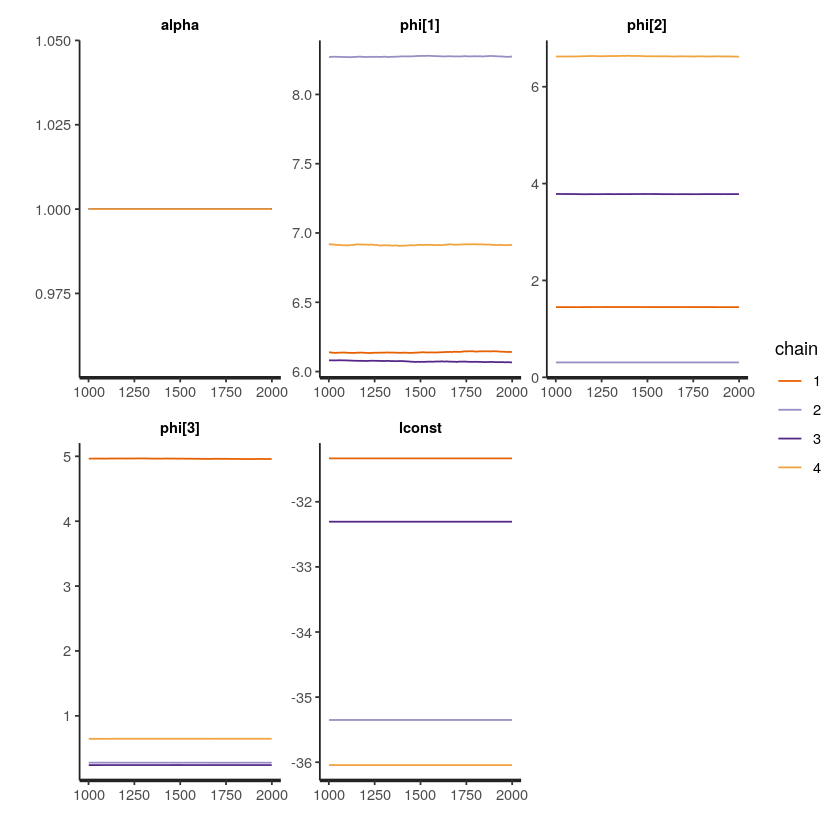

In [8]:
stan_trace(posterior.contplawDiff)

As you can see, Stan could not explore the posterior _at all_. Either there is a serious bug or the model has serious pathologies. Both, probably.